# 1.0 importing libs

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from colour import Color
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import matplotlib.patheffects as PathEffects
import matplotlib.lines as mlines

# 2.0 importing and cleanning dataset

In [2]:
#choose if you want to download from link or user a .csv file
data = pd.read_csv("https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv")
#data = pd.read_csv("gmr.csv")

data_br = data.loc[data.country_region=='Brazil'].iloc[:,[1,2,3,7,8,9,10,11,12,13]].copy()
data_br.columns=["country","state","city","date","retail","grocery","parks","transit","workplaces","residential"]
data_br.state = data_br.state.str.replace("State of ","")
data_br.date = pd.to_datetime(data_br.date)
data_br.index = data_br.date
data_br.drop(labels='date',axis=1,inplace=True)

display(data_br.head())

/home/joao/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,country,state,city,retail,grocery,parks,transit,workplaces,residential
date,,,,,,,,,
2020-02-15,Brazil,NaN,NaN,5.0,4.0,-5.0,8.0,6.0,0.0
2020-02-16,Brazil,NaN,NaN,2.0,3.0,-13.0,3.0,0.0,1.0
2020-02-17,Brazil,NaN,NaN,-2.0,0.0,-12.0,9.0,19.0,-1.0
2020-02-18,Brazil,NaN,NaN,-3.0,-1.0,-11.0,9.0,15.0,-1.0
2020-02-19,Brazil,NaN,NaN,-1.0,-2.0,-5.0,8.0,14.0,-1.0


# 3.0 Creating sub dataFrames

In [3]:
data_br_state = data_br.loc[~data_br.state.isnull() & data_br.city.isnull()].copy()

# 4.0 functions

In [4]:
#get the minimum and the last value from a pandas series
def getMinAndActual(serie):
    minimum = serie.loc[serie==serie.min()].tail(1)
    actual = serie.tail(1)
    return minimum.append(actual)
#get the percentage recover value of a pandas series
def recover(minimum,actual):
    value=0
    if(actual>=0):
        value = 100+abs((100/minimum)*actual)
    else:
        value = 100-abs((100/minimum)*abs(actual))
    return round(value,0)
#group and unstack a dataframe 
def groupAndUnstack(dataframe,firstBy,secondBy):
    return dataframe.groupby(by=[firstBy,secondBy]).mean().unstack()
#make a fancy plot of a highlighted panda series on an axes
def plotHighlight(ax,highlight):
    ax.plot(highlight,color='white',linewidth=7,zorder=1)
    highlight_min_actual = getMinAndActual(highlight)
    minimum = (highlight_min_actual.index[0],highlight_min_actual[0])
    actual = (highlight_min_actual.index[1],highlight_min_actual[1])
    colors = list(Color("blue").range_to(Color("cyan"),100))+list(Color("cyan").range_to(Color("yellow"),100))
    colorMap = []
    #generate color range for the entrys
    for entry in highlight:
        colorMap.append(colors[100+int(entry)].hex)
    #plot the gradient line
    for i in range(highlight.count()-1):
        x = (highlight.index[i],highlight.index[i+1])
        y = (highlight[i],highlight[i+1])
        ax.plot(x,y,colorMap[i],linewidth=4,zorder=2)
        if (x[0],y[0]) == minimum:
            ax.scatter(x[0],y[0],marker='o',alpha=1,color=colorMap[i],linewidth=8,zorder=3)
        if (x[1],y[1]) == actual:
            ax.scatter(x[1],y[1],marker='o',alpha=1,color=colorMap[i],linewidth=8,zorder=3)
    ax.set_xlim(right=pd.Timestamp(actual[0]+pd.DateOffset(5)))
    #annotate on the plot the minumum and actual values
    ax.annotate(str(round(minimum[1],0))+"%",xy=(minimum[0],minimum[1]),color='black',weight='bold',ha='right',path_effects=[PathEffects.withStroke(linewidth=4, foreground='w')],zorder=5)
    ax.annotate(str(round(actual[1],0))+"%",xy=(actual[0],actual[1]),color='black',weight='bold',ha='right',path_effects=[PathEffects.withStroke(linewidth=4, foreground='w')],zorder=5)
    #show difference between minimum and actual
    ax.plot([minimum[0],actual[0]],[minimum[1],minimum[1]],color="black",linestyle="--",linewidth=2)
    ax.plot([actual[0],actual[0]],[minimum[1],actual[1]],color="black",linestyle="--",linewidth=2)
    ax.annotate(str(recover(minimum[1],actual[1]))+"%",xy=(actual[0],(minimum[1]+actual[1])/2),color='red',weight='bold',ha='right',path_effects=[PathEffects.withStroke(linewidth=4, foreground='w')],zorder=5)
#simple plot gray lines on an axes
def simplePlot(ax,lines):
    lines.plot(ax=ax,color='grey',linewidth=2,alpha=0.4,legend=False,zorder=1)

# 5.0 Plotting data

In [5]:
print(plt.style.available)
plt.style.use('fivethirtyeight')

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


<ipython-input-6-bcf7e84ecc16>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["","Março","Abril","Maio","Junho","Julho","Agosto","Setembro"],fontsize=12)


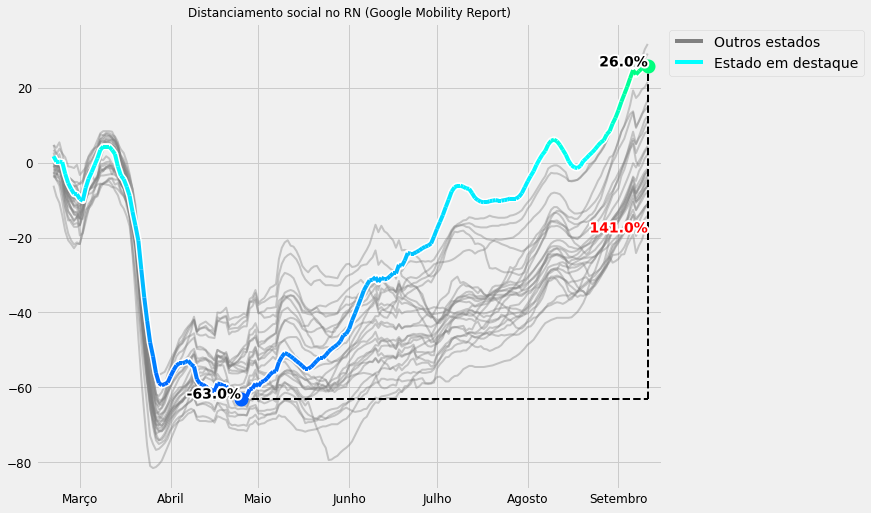

In [6]:
#create the subplot axe and figure
fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(10,8))

#change the figure target item and state
item='retail'
highlight_state = 'Amazonas'

#get the data
lines = groupAndUnstack(data_br_state,data_br_state.index,"state")[item].rolling(window=7).mean()
highlight = groupAndUnstack(data_br_state,data_br_state.index,"state")[item][highlight_state].fillna(method='ffill').rolling(window=7).mean()[6:].copy()

#plot lines
simplePlot(ax,lines)
plotHighlight(ax,highlight)

#create the legend lines
others_state = mlines.Line2D([], [],color='gray', label='Outros estados')
highlight_state =  mlines.Line2D([], [],color='cyan', label='Estado em destaque')
#change the plot legend, tick labels and title
ax.legend(handles=[others_state,highlight_state],loc='upper left', bbox_to_anchor=(1., 1.),ncol=1)
ax.set_xticklabels(["","Março","Abril","Maio","Junho","Julho","Agosto","Setembro"],fontsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.set_title("Distanciamento social no RN (Google Mobility Report)",fontsize=12)
ax.set_xlabel("")

#plt.savefig("MovingAverageFigure.png",dpi=300)
plt.show()

<ipython-input-8-5f8edf778845>:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i][j].set_xticklabels(labels)
<ipython-input-8-5f8edf778845>:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i][j].set_xticklabels(labels)
<ipython-input-8-5f8edf778845>:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i][j].set_xticklabels(labels)
<ipython-input-8-5f8edf778845>:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i][j].set_xticklabels(labels)
<ipython-input-8-5f8edf778845>:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i][j].set_xticklabels(labels)
<ipython-input-8-5f8edf778845>:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i][j].set_xticklabels(labels)
<ipython-input-8-5f8edf778845>:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i][j].set_xtick

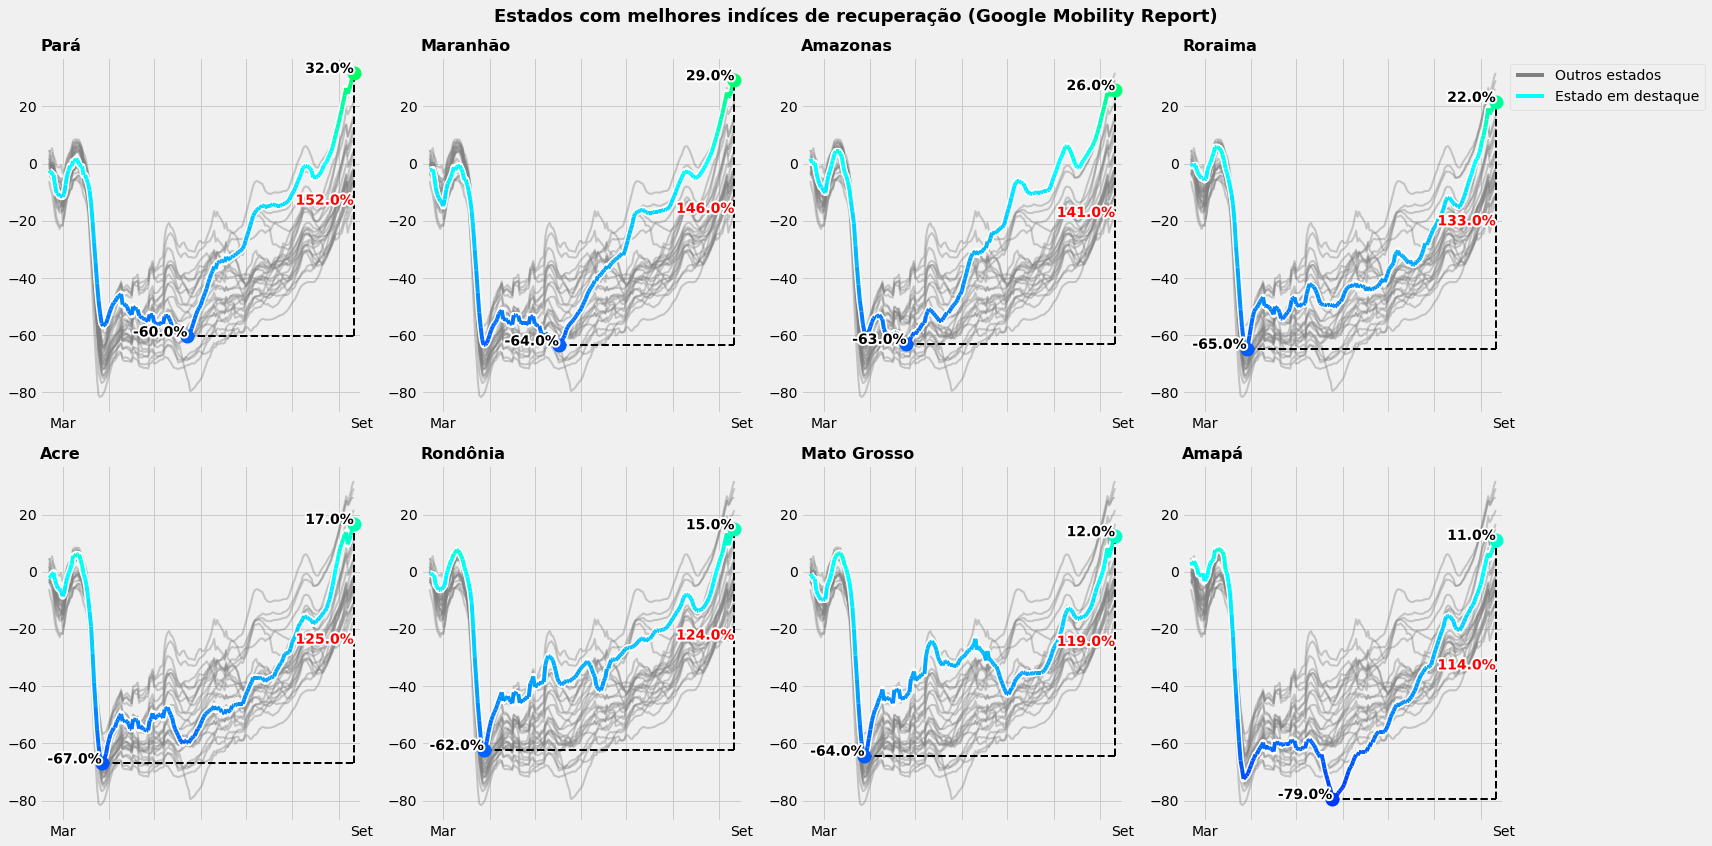

In [8]:
#define the figure number of graphics
lines=2
cols=4
size=lines*cols

#create the matplotlib subplots
fig,ax = plt.subplots(nrows=lines,ncols=cols,figsize=(cols*6,lines*6))

#change figure title and target item (google mobility report variable) to analize
fig.suptitle('Estados com melhores indíces de recuperação (Google Mobility Report)', fontsize=18,fontweight='bold')
item='retail'

#get the top states with better recover values
stacked = groupAndUnstack(data_br_state,data_br_state.index,"state")[item].rolling(window=7).mean()
top_states = stacked.apply(lambda x:recover(x.min(),x.iloc[-1])).sort_values(ascending=False).head(size)

#create the legend lines
others_state = mlines.Line2D([], [],color='gray', label='Outros estados')
highlight_state =  mlines.Line2D([], [],color='cyan', label='Estado em destaque')

#with the type (line x cols) type of figure, plot the data
if(size==1):
    state = top_states.index[0]

    lines = groupAndUnstack(data_br_state,data_br_state.index,"state")[item].rolling(window=7).mean()
    highlight = groupAndUnstack(data_br_state,data_br_state.index,"state")[item][state].fillna(method='ffill').rolling(window=7).mean()[6:].copy()

    simplePlot(ax,lines)
    plotHighlight(ax,highlight)

    ax.set_title(state,fontsize=16,loc='left',fontweight='bold')
    ax.set_xlabel("")
    labels = ["" for item in ax.get_xticklabels()]
    labels[1]="Mar"
    labels[len(labels)-1]="Set"
    ax.set_xticklabels(labels)
    ax.legend(handles=[others_state,highlight_state],loc='upper left', bbox_to_anchor=(1., 1.),ncol=1)
elif(lines==1 or cols==1):
    for i in range(size):
        state = top_states.index[i]

        lines = groupAndUnstack(data_br_state,data_br_state.index,"state")[item].rolling(window=7).mean()
        highlight = groupAndUnstack(data_br_state,data_br_state.index,"state")[item][state].fillna(method='ffill').rolling(window=7).mean()[6:].copy()

        simplePlot(ax[i],lines)
        plotHighlight(ax[i],highlight)

        ax[i].set_title(state,fontsize=16,loc='left',fontweight='bold')
        ax[i].set_xlabel("")
        labels = ["" for item in ax[i].get_xticklabels()]
        labels[1]="Mar"
        labels[len(labels)-1]="Set"
        ax[i].set_xticklabels(labels)
        ax[size-1].legend(handles=[others_state,highlight_state],loc='upper left', bbox_to_anchor=(1., 1.),ncol=1)
else:
    for i in range(lines):
        for j in range(cols):
            state = top_states.index[i*cols+j]

            lines = groupAndUnstack(data_br_state,data_br_state.index,"state")[item].rolling(window=7).mean()
            highlight = groupAndUnstack(data_br_state,data_br_state.index,"state")[item][state].fillna(method='ffill').rolling(window=7).mean()[6:].copy()

            simplePlot(ax[i][j],lines)
            plotHighlight(ax[i][j],highlight)

            ax[i][j].set_title(state,fontsize=16,loc='left',fontweight='bold')
            ax[i][j].set_xlabel("")
            labels = ["" for item in ax[i][j].get_xticklabels()]
            labels[1]="Mar"
            labels[len(labels)-1]="Set"
            ax[i][j].set_xticklabels(labels)
            ax[0][cols-1].legend(handles=[others_state,highlight_state],loc='upper left', bbox_to_anchor=(1., 1.),ncol=1)

plt.tight_layout()
plt.savefig("1FP.png",dpi=200)
plt.show()